In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33027")
client

<Client: 'tcp://127.0.0.1:33027' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
import MITgcmutils as mitutils
from xmitgcm import open_mdsdataset
# from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
# savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
savedir = '/tank/spectre/tuchida/diagnostics/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]
reg = 0

xo = 50e3

xchunk = 200
ychunk = 200

In [8]:
iiter = 1419120
dg = 0

dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                           YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                           XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                           XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                          ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

# dsUmb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
#                         grid_dir=gdir,
#                         prefix=['diagUm'], delta_t=2e2,
#                         iters=iiter, 
#                         ignore_unknown_vars=True
#                        ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
#                              YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
#                              XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
#                              XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
#                             ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
if len(dsb.XG) > len(dsb.XC):
     dsb = dsb.isel(XG=slice(None,-1))
# if len(dsUmb.XG) > len(dsb.XC):
#      dsUmb = dsUmb.isel(XG=slice(None,-1))

# dsVmb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
#                         grid_dir=gdir,
#                         prefix=['diagVm'], delta_t=2e2,
#                         iters=iiter, 
#                         ignore_unknown_vars=True
#                        ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
#                              YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
#                              XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
#                              XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
#                             ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

dsb.Z.isel(Z=9)

<xarray.DataArray 'Z' ()>
array(-93.594124, dtype=float32)
Coordinates:
    iter     int64 dask.array<chunksize=(), meta=np.ndarray>
    time     timedelta64[ns] 3285 days
    Z        >f4 -93.59
    drF      >f4 dask.array<chunksize=(), meta=np.ndarray>
    PHrefC   >f4 dask.array<chunksize=(), meta=np.ndarray>
    rhoRef   >f4 dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    standard_name:  depth
    long_name:      vertical coordinate of cell center
    units:          m
    positive:       down
    axis:           Z

In [7]:
grid = Grid(dsb, periodic=[], 
            # coords={'Z': {'center': 'Z', 'outer': 'Zp1', 'left':'Zl', 'right':'Zu'},
            #                           'Y': {'center': 'YC', 'left': 'YG'},
            #                           'X': {'center': 'XC', 'left': 'XG'}}
           )
grid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * outer    Zp1 --> center
  * right    Zu --> center
  * left     Zl --> center

In [9]:
nmembs = np.arange(100,148)

for nmemb in nmembs:
    if nmemb == 100:
        ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                             ignore_unknown_vars=True
                            ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                               YG=slice(ys[reg]-5,ys[reg]+5),
                                               XC=slice(xs[reg]-5,xs[reg]+5),
                                               XG=slice(xs[reg]-5,xs[reg]+5)
                                              )
    else:
        ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                             ignore_unknown_vars=True
                            ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                               YG=slice(ys[reg]-5,ys[reg]+5),
                                               XC=slice(xs[reg]-5,xs[reg]+5),
                                               XG=slice(xs[reg]-5,xs[reg]+5)
                                              )
        ds = xr.concat([ds, ds1], dim='nmemb')
        ds1.close()
    print(nmemb)

ds.coords['nmemb'] = ('nmemb',nmembs)
if len(ds.XG) > len(ds.XC):
     ds = ds.isel(XG=slice(None,-1))
ds

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


<xarray.Dataset>
Dimensions:  (XC: 116, YC: 120, XG: 116, YG: 120, Z: 46, Zp1: 47, Zu: 46,
              Zl: 46, nmemb: 48)
Coordinates: (12/34)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XG       (XG) >f4 290.0 290.1 290.2 290.3 290.4 ... 299.7 299.7 299.8 299.9
  * YG       (YG) >f4 32.04 32.13 32.21 32.29 32.38 ... 41.71 41.79 41.88 41.96
    ...       ...
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 120, 116), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
    rhoRef   (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW  (YC, XG) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
Data variables:
    THETA    (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    SALT     (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    UVEL     (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    VVEL     (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    WVEL     (nmemb, Zl, YC, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [6]:
def advec_um(ds, u, cori=False, metr=False, xgcm_flag=True):

    '''
    Compute the 3D advection and advective fluxes
    of zonal momentum.

    Input:
       - u, v, w: three dimensional velocity field
       - grd: list of model grid varaibles
    Output:
       - ADVx_Um, ADVy_Um, ADVrE_Um: zonal, meridional and vertical u-momentum flux
       - Um_Advec: u-momentum flux divergence.
                   In MITgcm diagnostics, Um_Advec also includes 
                   Coriolis (Um_Cori) and metric term (Um_metr).
                   They can be computed and added with cori=True and metr=True (to be done)
    '''

    #-- grid --
    dxG = ds.dxG
    dyG = ds.dyG
    drF = ds.drF
    hW  = ds.hFacW
    hS  = ds.hFacS
    hC  = ds.hFacC
    rA  = ds.rA
    rAw = ds.rAw
    uuu = ds.UVEL
    vvv = ds.VVEL
    www = ds.WVEL
    #
    xA = (drF * dyG * hW)
    yA = (drF * dxG * hS)
    maskC = hC.load().data * 1.0
    maskC[ np.where(maskC > 0. ) ] = 1.0
    maskC = xr.DataArray(data=maskC,
                         dims=hC.dims, coords=hC.coords)

    #-- get and check dimensions --
    [nr, ny, nx] = hW.shape
    tmp = nr*ny*nx
    # if np.size(u)!=np.size(vvv) or np.size(u)!=np.size(ds.WVEL) or np.size(u)!=tmp:
    #     raise ValueError("advec_um: velocity field do not have the same/right dimension")
    #

    #-- zonal advective flux of U (from mom_u_adv_uu.F) --
    #- transport -
    uTrans = uuu * xA
    #- adv flux -
    if xgcm_flag:
        grid = Grid(ds, periodic=['X'])
        ADVx_Um = (grid.interp(uTrans, 'X')
                   * grid.interp(   u, 'X')
                  )
    else:
        ADVx_Um = np.zeros_like(hW.data)
        ADVx_Um[:, :, :-1] = \
                0.25 *(uTrans[:, :, :-1].data + uTrans[:, :, 1:].data ) \
                     *(   u[:, :, :-1].data +    u[:, :, 1:].data   )
    
    #-- meridional advective flux of U (from mom_u_adv_vu.F) --
    #- transport -
    vTrans = vvv * yA
    #- adv flux -
    if xgcm_flag:
        ADVy_Um = (grid.interp(vTrans, 'X') 
                   * grid.interp(   u, 'Y', boundary='extend')
                  )
    else:
        ADVy_Um = np.zeros_like(hW.data)
        ADVy_Um[:, 1:, 1:] = \
                0.25 *(vTrans[:, 1:, 1:].data + vTrans[:, 1:, :-1].data ) \
                     *(   u[:, 1:, 1:].data +    u[:, :-1, 1:].data   )
    
    #-- vertical advective flux of U (from mom_u_adv_wu.F) --
    #- transport -
    # rTransU :: vertical transport (above U point)
    if xgcm_flag:
        rTransU = grid.interp(ds.WVEL*rA, 'X')
        ADVrE_Um = xr.zeros_like(rTransU)
        ADVrE_Um[dict(Zl=0)] = rTransU.isel(Zl=0) * u.isel(Z=0)
        ADVrE_Um[dict(Zl=slice(1,None))] = (rTransU.isel(Zl=slice(1,None)) 
                          * grid.interp(u,'Z',boundary='extend').isel(Zl=slice(1,None))
                                           )
        ADVrE_Um[dict(Zl=slice(1,None))] += .5*(
              grid.interp(ds.WVEL * rA
                          * grid.diff(maskC,'Z',boundary='extend'),
                          'X'
                         ).isel(Zl=slice(1,None)) 
              * u.isel(Z=slice(1,None)).data
                                        )
    else:
        rTransU = np.zeros_like(hW.data)
        rTransU[:, :, 1:] = \
                0.5 * ( www[:, :, :-1].data * rA.data[np.newaxis, :, :-1] \
                       +www[:, :, 1: ].data * rA.data[np.newaxis, :, 1: ] )

        # - advective flux -
        # surface layer 
        ADVrE_Um = np.zeros_like(hW.data)
        ADVrE_Um[0, :, :] = rTransU[0, :, :] * u[0, :, :].data

        # ADVrE_Um[0, :, :] = 0.0         # rigid lid, for checking
        # interior flux
        ADVrE_Um[1:, :, :] = rTransU[1:, :, :] * \
                0.5 * ( u[1:, :, :].data + u[:-1, :, :].data)

        # (linear) Free-surface correction at k>1
        ADVrE_Um[1:, :, 1:] = ADVrE_Um[1:, :, 1:] \
                + 0.25 * (\
                  www[1:, :, 1:].data * rA.data[np.newaxis, :, 1:] *\
                    (maskC[1:, :, 1:].data - maskC[:-1, :, 1:].data) \
                 +www[1:, :, :-1].data * rA.data[np.newaxis, :, :-1] *\
                    (maskC[1:, :, :-1].data - maskC[:-1, :, :-1].data) \
                         ) * u[1:, :, 1:]
    
        
    
    #-- flux divergence (from mom_fluxform.F) --
    if xgcm_flag:
        gUx = - grid.diff(ADVx_Um, 'X') / (hW * drF * rAw)
        gUy = - grid.diff(ADVy_Um, 'Y', boundary='extend'
                         )/ (hW * drF * rAw)
        gUz = xr.zeros_like(ds.UVEL)
        gUz[dict(Z=slice(None,-1))] = - (-grid.diff(ADVrE_Um,'Z',boundary='extend'
                                                     ).isel(Z=slice(None,-1)) 
                                         / (hW * drF * rAw).isel(Z=slice(None,-1)) 
                                        )
        gUz[dict(Z=-1)] = - ((ADVrE_Um.isel(Zl=-1) - 0.0)
                             / (hW * drF * rAw).isel(Z=-1)
                            )
        Um_Advec = (gUx + gUy + gUz).reset_coords(drop=True)
    else:
        #- zonal -
        gUx = np.zeros_like(hW.data)
        gUx[:, :, 1:] = - 1 / (hW * drF * rAw).data[:, :, 1:] \
                * (ADVx_Um[:, :, 1:] - ADVx_Um[:, :, :-1])
        #- meridional -
        gUy = np.zeros_like(hW.data)
        gUy[:, :-1, :] = - 1 / (hW * drF * rAw).data[:, :-1, :] \
                * (ADVy_Um[:, 1:, :] - ADVy_Um[:, :-1, :])
        #- vertical -
        gUz = np.zeros_like(hW.data)
        gUz[:-1, :, :] = - 1 / (hW * drF * rAw).data[:-1, :, :] \
                * (ADVrE_Um[:-1, :, :] - ADVrE_Um[1:, :, :])
        gUz[-1, :, :] = - 1 / (hW * drF * rAw).data[-1, :, :] \
                * (ADVrE_Um[-1, :, :] - 0.0)     #no bottom flux at bottom cell
        if cori:
            print("Include Coriolis and metric terms in Um_Advec (following MITgcm diagnostic package convention)")
            print("TO BE DONE (07/21/2023)")
        #- total -
        Um_Advec = xr.DataArray(gUx + gUy + gUz, dims=ds.UVEL.dims, coords=ds.UVEL.coords
                               ).reset_coords(drop=True)

    return (Um_Advec, 
            (ADVx_Um
             / grid.interp(drF * dyG * hW,'X')
            ).reset_coords(drop=True), 
            (ADVy_Um
             / grid.interp(drF * dxG * hS,'X')
            ).reset_coords(drop=True),
            (ADVrE_Um
             / grid.interp(rAw * hW,'Z',boundary='extend')
            ).reset_coords(drop=True)
           )


def advec_vm(ds, v, cori=False, metr=False, xgcm_flag=True):

    '''
    Compute the 3D advection and advective fluxes
    of meridional momentum.

    Input:
       - u, v, w: three dimensional velocity field
       - grd: list of model grid varaibles
    Output:
       - ADVx_Vm, ADVy_Vm, ADVrE_Vm: zonal, meridional and vertical v-momentum flux
       - Vm_Advec: v-momentum flux divergence.
                   In MITgcm diagnostics, Vm_Advec also includes 
                   Coriolis (Vm_Cori) and metric term (Vm_metr).
                   They can be computed and added with cori=True and metr=True (to be done)
    '''

    #-- grid --
    dxG = ds.dxG
    dyG = ds.dyG
    drF = ds.drF
    hW  = ds.hFacW
    hS  = ds.hFacS
    hC  = ds.hFacC
    rA  = ds.rA
    rAs = ds.rAs
    uuu = ds.UVEL
    vvv = ds.VVEL
    www = ds.WVEL
    #
    xA = (drF * dyG * hW)
    yA = (drF * dxG * hS)
    maskC = hC.load().data * 1.0
    maskC[ np.where(maskC > 0. ) ] = 1.0
    maskC = xr.DataArray(data=maskC,
                         dims=hC.dims, coords=hC.coords)

    #-- get and check dimensions --
    [nr, ny, nx] = hS.shape
    tmp = nr*ny*nx
    # if np.size(uuu)!=np.size(v) or np.size(v)!=np.size(ds.WVEL) or np.size(v)!=tmp:
    #     raise ValueError("advec_vm: velocity field do not have the same/right dimension")
    #
    
    #-- zonal advective flux of V (mom_v_adv_uv.F) --
    #- transport -
    uTrans = uuu * xA
    #- adv flux -
    if xgcm_flag:
        grid = Grid(ds, periodic=['X'])
        ADVx_Vm = (grid.interp(uTrans, 'Y', boundary='extend') 
               * grid.interp(   v, 'X')
              )
    else:
        ADVx_Vm = np.zeros_like(hS.data)
        ADVx_Vm[:, 1:, 1:] = \
            0.25 *(uTrans[:, 1:, 1:].data + uTrans[:, :-1, 1:].data ) \
                 *(   v[:, 1:, 1:].data + v[:, 1:, :-1].data    )

    #-- meridional advective flux of V (from mom_v_adv_vv.F) --
    #- transport -
    vTrans = vvv * yA
    #- adv flux -
    if xgcm_flag:
        ADVy_Vm = (grid.interp(vTrans, 'Y', boundary='extend') 
               * grid.interp(   v, 'Y', boundary='extend')
              )
    else:
        ADVy_Vm = np.zeros_like(hS.data)
        ADVy_Vm[:, :-1, :] = \
                0.25 *(vTrans[:, :-1, :].data + vTrans[:, 1:, :].data ) \
                     *(   v[:, :-1, :].data + v[:, 1:, :].data   )

    #-- vertical advective flux of V (mom_v_adv_wv.F) --
    #- transport -
    # rTransV :: vertical transport (above V point) 
    if xgcm_flag:
        rTransV = grid.interp(ds.WVEL*rA, 'Y', boundary='extend')
        ADVrE_Vm = xr.zeros_like(rTransV)
        ADVrE_Vm[dict(Zl=0)] = rTransV.isel(Zl=0) * v.isel(Z=0)
        ADVrE_Vm[dict(Zl=slice(1,None))] = (rTransV.isel(Zl=slice(1,None)) 
                          * grid.interp(v,'Z',boundary='extend').isel(Zl=slice(1,None))
                                           )
        ADVrE_Vm[dict(Zl=slice(1,None))] += .5*(
              grid.interp(ds.WVEL * rA
                          * grid.diff(maskC,'Z',boundary='extend'),
                          'Y',boundary='extend'
                         ).isel(Zl=slice(1,None)) 
              * v.isel(Z=slice(1,None)).data
                                        )
    else:
        rTransV = np.zeros_like(hS.data)
        rTransV[:, 1:, :] = \
                0.5 * ( www[:, :-1, :].data * rA.data[np.newaxis, :-1, :] \
                       +www[:, 1: , :].data * rA.data[np.newaxis, 1: , :] )
        #- advective flux -
        # surface layer 
        ADVrE_Vm = np.zeros_like(hS.data)
        ADVrE_Vm[0, :, :] = rTransV[0, :, :] * v[0, :, :].data
        #ADVrE_Vm[0, :, :] = 0.0         # rigid lid, for checking
        # interior flux
        ADVrE_Vm[1:, :, :] = rTransV[1:, :, :] * \
                0.5 * ( v[1:, :, :].data + v[:-1, :, :].data)
        # (linear) Free-surface correction at k>1
        ADVrE_Vm[1:, 1:, :] = ADVrE_Vm[1:, 1:, :] \
                + 0.25 * (\
                  www[1:, 1:, :].data * rA.data[np.newaxis, 1:, :] *\
                    (maskC[1:, 1:, :].data - maskC[:-1, 1:, :].data) \
                 +www[1:, :-1, :].data * rA.data[np.newaxis, :-1, :] *\
                    (maskC[1:, :-1, :].data - maskC[:-1, :-1, :].data) \
                         ) * v[1:, 1:, :].data
        

    #-- flux divergence (mom_fluxform.F) --
    if xgcm_flag:
        gVx = - grid.diff(ADVx_Vm, 'X') / (hS * drF * rAs)
        gVy = - grid.diff(ADVy_Vm, 'Y', boundary='extend'
                         ) / (hS * drF * rAs)
        gVz = xr.zeros_like(ds.VVEL)
        gVz[dict(Z=slice(None,-1))] = - (-grid.diff(ADVrE_Vm,'Z',boundary='extend'
                                                   ).isel(Z=slice(None,-1)) 
                                         / (hS * drF * rAs).isel(Z=slice(None,-1))
                                        )
        gVz[dict(Z=-1)] = - ((ADVrE_Vm.isel(Zl=-1) - 0.0)
                             / (hS * drF * rAs).isel(Z=-1)
                            )
        Vm_Advec = (gVx + gVy + gVz).reset_coords(drop=True)
    else:
    #- zonal -
        gVx = np.zeros_like(hS.data)
        gVx[:, :, :-1] = - 1 / (hS * drF * rAs).data[:, :, :-1] \
                * (ADVx_Vm[:, :, 1:] - ADVx_Vm[:, :, :-1])
        #- meridional -
        gVy = np.zeros_like(hS.data)
        gVy[:, 1:, :] = - 1 / (hS * drF * rAs).data[:, 1:, :] \
                * (ADVy_Vm[:, 1:, :] - ADVy_Vm[:, :-1, :])
        #- vertical -
        gVz = np.zeros_like(hS.data)
        gVz[:-1, :, :] = - 1 / (hS * drF * rAs).data[:-1, :, :] \
                * (ADVrE_Vm[:-1, :, :] - ADVrE_Vm[1:, :, :])
        gVz[-1, :, :] = - 1 / (hS * drF * rAs).data[-1, :, :] \
                * (ADVrE_Vm[-1, :, :] - 0.0)     #no bottom flux at bottom cell
        if cori:
            print("Include Coriolis and metric terms in Vm_Advec (following MITgcm diagnostic package convention)")
            print("TO BE DONE (07/21/2023)")
        #- total -
        Vm_Advec = xr.DataArray(gVx + gVy + gVz, dims=ds.VVEL.dims, coords=ds.VVEL.coords
                               ).reset_coords(drop=True)

    return (Vm_Advec, 
            (ADVx_Vm 
             / grid.interp(drF * dyG * hW,'Y',boundary='extend')
            ).reset_coords(drop=True), 
            (ADVy_Vm 
             / grid.interp(drF * dxG * hS,'Y',boundary='extend')
            ).reset_coords(drop=True),
            (ADVrE_Vm
             / grid.interp(rAs * hS,'Z',boundary='extend')
            ).reset_coords(drop=True)
           )

In [7]:
def hori_advec_um(ds, u, cori=False, metr=False, xgcm_flag=True):

    '''
    Compute the 2D advection and advective fluxes
    of zonal momentum.

    Input:
       - u, v, w: three dimensional velocity field
       - grd: list of model grid varaibles
    Output:
       - ADVx_Um, ADVy_Um, ADVrE_Um: zonal, meridional and vertical u-momentum flux
       - Um_Advec: u-momentum flux divergence.
                   In MITgcm diagnostics, Um_Advec also includes 
                   Coriolis (Um_Cori) and metric term (Um_metr).
                   They can be computed and added with cori=True and metr=True (to be done)
    '''

    #-- grid --
    dxG = ds.dxG
    dyG = ds.dyG
    drF = ds.drF
    hW  = ds.hFacW
    hS  = ds.hFacS
    hC  = ds.hFacC
    rA  = ds.rA
    rAw = ds.rAw
    uuu = ds.UVEL
    vvv = ds.VVEL
    # www = ds.WVEL
    #
    xA = (drF * dyG * hW)
    yA = (drF * dxG * hS)
    maskC = hC.load().data * 1.0
    maskC[ np.where(maskC > 0. ) ] = 1.0
    maskC = xr.DataArray(data=maskC,
                         dims=hC.dims, coords=hC.coords)

    #-- get and check dimensions --
    [nr, ny, nx] = hW.shape
    tmp = nr*ny*nx
    # if np.size(u)!=np.size(vvv) or np.size(u)!=np.size(ds.WVEL) or np.size(u)!=tmp:
    #     raise ValueError("advec_um: velocity field do not have the same/right dimension")
    #

    #-- zonal advective flux of U (from mom_u_adv_uu.F) --
    #- transport -
    uTrans = uuu * xA
    #- adv flux -
    if xgcm_flag:
        grid = Grid(ds, periodic=['X'])
        ADVx_Um = (grid.interp(uTrans, 'X')
                   * grid.interp(   u, 'X')
                  )
    else:
        ADVx_Um = np.zeros_like(hW.data)
        ADVx_Um[:, :, :-1] = \
                0.25 *(uTrans[:, :, :-1].data + uTrans[:, :, 1:].data ) \
                     *(   u[:, :, :-1].data +    u[:, :, 1:].data   )
    
    #-- meridional advective flux of U (from mom_u_adv_vu.F) --
    #- transport -
    vTrans = vvv * yA
    #- adv flux -
    if xgcm_flag:
        ADVy_Um = (grid.interp(vTrans, 'X') 
                   * grid.interp(   u, 'Y', boundary='extend')
                  )
    else:
        ADVy_Um = np.zeros_like(hW.data)
        ADVy_Um[:, 1:, 1:] = \
                0.25 *(vTrans[:, 1:, 1:].data + vTrans[:, 1:, :-1].data ) \
                     *(   u[:, 1:, 1:].data +    u[:, :-1, 1:].data   )
    
#     #-- vertical advective flux of U (from mom_u_adv_wu.F) --
#     #- transport -
#     # rTransU :: vertical transport (above U point)
#     if xgcm_flag:
#         rTransU = grid.interp(ds.WVEL*rA, 'X')
#         ADVrE_Um = xr.zeros_like(rTransU)
#         ADVrE_Um[dict(Zl=0)] = rTransU.isel(Zl=0) * u.isel(Z=0)
#         ADVrE_Um[dict(Zl=slice(1,None))] = (rTransU.isel(Zl=slice(1,None)) 
#                           * grid.interp(u,'Z',boundary='extend').isel(Zl=slice(1,None))
#                                            )
#         ADVrE_Um[dict(Zl=slice(1,None))] += .5*(
#               grid.interp(ds.WVEL * rA
#                           * grid.diff(maskC,'Z',boundary='extend'),
#                           'X'
#                          ).isel(Zl=slice(1,None)) 
#               * u.isel(Z=slice(1,None)).data
#                                         )
#     else:
#         rTransU = np.zeros_like(hW.data)
#         rTransU[:, :, 1:] = \
#                 0.5 * ( www[:, :, :-1].data * rA.data[np.newaxis, :, :-1] \
#                        +www[:, :, 1: ].data * rA.data[np.newaxis, :, 1: ] )

#         # - advective flux -
#         # surface layer 
#         ADVrE_Um = np.zeros_like(hW.data)
#         ADVrE_Um[0, :, :] = rTransU[0, :, :] * u[0, :, :].data

#         # ADVrE_Um[0, :, :] = 0.0         # rigid lid, for checking
#         # interior flux
#         ADVrE_Um[1:, :, :] = rTransU[1:, :, :] * \
#                 0.5 * ( u[1:, :, :].data + u[:-1, :, :].data)

#         # (linear) Free-surface correction at k>1
#         ADVrE_Um[1:, :, 1:] = ADVrE_Um[1:, :, 1:] \
#                 + 0.25 * (\
#                   www[1:, :, 1:].data * rA.data[np.newaxis, :, 1:] *\
#                     (maskC[1:, :, 1:].data - maskC[:-1, :, 1:].data) \
#                  +www[1:, :, :-1].data * rA.data[np.newaxis, :, :-1] *\
#                     (maskC[1:, :, :-1].data - maskC[:-1, :, :-1].data) \
#                          ) * u[1:, :, 1:]
    
        
    
    #-- flux divergence (from mom_fluxform.F) --
    if xgcm_flag:
        gUx = - grid.diff(ADVx_Um, 'X') / (hW * drF * rAw)
        gUy = - grid.diff(ADVy_Um, 'Y', boundary='extend'
                         ) / (hW * drF * rAw)
        # gUz = xr.zeros_like(ds.UVEL)
        # gUz[dict(Z=slice(None,-1))] = - (1 / (hW * drF * rAw).isel(Z=slice(None,-1)) 
        #                                  * -grid.diff(ADVrE_Um,'Z',boundary='extend'
        #                                              ).isel(Z=slice(None,-1)) 
        #                                 )
        # gUz[dict(Z=-1)] = - (1 / (hW * drF * rAw).isel(Z=-1) 
        #                      * (ADVrE_Um.isel(Zl=-1).data - 0.0)
        #                     )
        Um_Advec = (gUx + gUy).reset_coords(drop=True)
    else:
        #- zonal -
        gUx = np.zeros_like(hW.data)
        gUx[:, :, 1:] = - 1 / (hW * drF * rAw).data[:, :, 1:] \
                * (ADVx_Um[:, :, 1:] - ADVx_Um[:, :, :-1])
        #- meridional -
        gUy = np.zeros_like(hW.data)
        gUy[:, :-1, :] = - 1 / (hW * drF * rAw).data[:, :-1, :] \
                * (ADVy_Um[:, 1:, :] - ADVy_Um[:, :-1, :])
        # #- vertical -
        # gUz = np.zeros_like(hW.data)
        # gUz[:-1, :, :] = - 1 / (hW * drF * rAw).data[:-1, :, :] \
        #         * (ADVrE_Um[:-1, :, :] - ADVrE_Um[1:, :, :])
        # gUz[-1, :, :] = - 1 / (hW * drF * rAw).data[-1, :, :] \
        #         * (ADVrE_Um[-1, :, :] - 0.0)     #no bottom flux at bottom cell
        if cori:
            print("Include Coriolis and metric terms in Um_Advec (following MITgcm diagnostic package convention)")
            print("TO BE DONE (07/21/2023)")
        #- total -
        Um_Advec = xr.DataArray(gUx + gUy, dims=ds.UVEL.dims, coords=ds.UVEL.coords
                               ).reset_coords(drop=True)

    return (Um_Advec, 
            (ADVx_Um
             / grid.interp(drF * dyG * hW,'X')
            ).reset_coords(drop=True), 
            (ADVy_Um
             / grid.interp(drF * dxG * hS,'X')
            ).reset_coords(drop=True))


def hori_advec_vm(ds, v, cori=False, metr=False, xgcm_flag=True):

    '''
    Compute the 2D advection and advective fluxes
    of meridional momentum.

    Input:
       - u, v, w: three dimensional velocity field
       - grd: list of model grid varaibles
    Output:
       - ADVx_Vm, ADVy_Vm, ADVrE_Vm: zonal, meridional and vertical v-momentum flux
       - Vm_Advec: v-momentum flux divergence.
                   In MITgcm diagnostics, Vm_Advec also includes 
                   Coriolis (Vm_Cori) and metric term (Vm_metr).
                   They can be computed and added with cori=True and metr=True (to be done)
    '''

    #-- grid --
    dxG = ds.dxG
    dyG = ds.dyG
    drF = ds.drF
    hW  = ds.hFacW
    hS  = ds.hFacS
    hC  = ds.hFacC
    rA  = ds.rA
    rAs = ds.rAs
    uuu = ds.UVEL
    vvv = ds.VVEL
    # www = ds.WVEL
    #
    xA = (drF * dyG * hW)
    yA = (drF * dxG * hS)
    maskC = hC.load().data * 1.0
    maskC[ np.where(maskC > 0. ) ] = 1.0
    maskC = xr.DataArray(data=maskC,
                         dims=hC.dims, coords=hC.coords)

    #-- get and check dimensions --
    [nr, ny, nx] = hS.shape
    tmp = nr*ny*nx
    # if np.size(uuu)!=np.size(v) or np.size(v)!=np.size(ds.WVEL) or np.size(v)!=tmp:
    #     raise ValueError("advec_vm: velocity field do not have the same/right dimension")
    #
    
    #-- zonal advective flux of V (mom_v_adv_uv.F) --
    #- transport -
    uTrans = uuu * xA
    #- adv flux -
    if xgcm_flag:
        grid = Grid(ds, periodic=['X'])
        ADVx_Vm = (grid.interp(uTrans, 'Y', boundary='extend') 
               * grid.interp(   v, 'X')
              )
    else:
        ADVx_Vm = np.zeros_like(hS.data)
        ADVx_Vm[:, 1:, 1:] = \
            0.25 *(uTrans[:, 1:, 1:].data + uTrans[:, :-1, 1:].data ) \
                 *(   v[:, 1:, 1:].data + v[:, 1:, :-1].data    )

    #-- meridional advective flux of V (from mom_v_adv_vv.F) --
    #- transport -
    vTrans = vvv * yA
    #- adv flux -
    if xgcm_flag:
        ADVy_Vm = (grid.interp(vTrans, 'Y', boundary='extend') 
               * grid.interp(   v, 'Y', boundary='extend')
              )
    else:
        ADVy_Vm = np.zeros_like(hS.data)
        ADVy_Vm[:, :-1, :] = \
                0.25 *(vTrans[:, :-1, :].data + vTrans[:, 1:, :].data ) \
                     *(   v[:, :-1, :].data + v[:, 1:, :].data   )

    # #-- vertical advective flux of V (mom_v_adv_wv.F) --
    # #- transport -
    # # rTransV :: vertical transport (above V point) 
    # if xgcm_flag:
    #     rTransV = grid.interp(ds.WVEL*rA, 'Y', boundary='extend')
    #     ADVrE_Vm = xr.zeros_like(rTransV)
    #     ADVrE_Vm[dict(Zl=0)] = rTransV.isel(Zl=0) * v.isel(Z=0)
    #     ADVrE_Vm[dict(Zl=slice(1,None))] = (rTransV.isel(Zl=slice(1,None)) 
    #                       * grid.interp(v,'Z',boundary='extend').isel(Zl=slice(1,None))
    #                                        )
    #     ADVrE_Vm[dict(Zl=slice(1,None))] += .5*(
    #           grid.interp(ds.WVEL * rA
    #                       * grid.diff(maskC,'Z',boundary='extend'),
    #                       'Y',boundary='extend'
    #                      ).isel(Zl=slice(1,None)) 
    #           * v.isel(Z=slice(1,None)).data
    #                                     )
    # else:
    #     rTransV = np.zeros_like(hS.data)
    #     rTransV[:, 1:, :] = \
    #             0.5 * ( www[:, :-1, :].data * rA.data[np.newaxis, :-1, :] \
    #                    +www[:, 1: , :].data * rA.data[np.newaxis, 1: , :] )
    #     #- advective flux -
    #     # surface layer 
    #     ADVrE_Vm = np.zeros_like(hS.data)
    #     ADVrE_Vm[0, :, :] = rTransV[0, :, :] * v[0, :, :].data
    #     #ADVrE_Vm[0, :, :] = 0.0         # rigid lid, for checking
    #     # interior flux
    #     ADVrE_Vm[1:, :, :] = rTransV[1:, :, :] * \
    #             0.5 * ( v[1:, :, :].data + v[:-1, :, :].data)
    #     # (linear) Free-surface correction at k>1
    #     ADVrE_Vm[1:, 1:, :] = ADVrE_Vm[1:, 1:, :] \
    #             + 0.25 * (\
    #               www[1:, 1:, :].data * rA.data[np.newaxis, 1:, :] *\
    #                 (maskC[1:, 1:, :].data - maskC[:-1, 1:, :].data) \
    #              +www[1:, :-1, :].data * rA.data[np.newaxis, :-1, :] *\
    #                 (maskC[1:, :-1, :].data - maskC[:-1, :-1, :].data) \
    #                      ) * v[1:, 1:, :].data
        

    #-- flux divergence (mom_fluxform.F) --
    if xgcm_flag:
        gVx = - grid.diff(ADVx_Vm, 'X') / (hS * drF * rAs)
        gVy = - grid.diff(ADVy_Vm, 'Y', boundary='extend'
                         ) / (hS * drF * rAs)
        # gVz = xr.zeros_like(ds.VVEL)
        # gVz[dict(Z=slice(None,-1))] = - (1 / (hS * drF * rAs).isel(Z=slice(None,-1)) 
        #                                  * -grid.diff(ADVrE_Vm,'Z',boundary='extend'
        #                                              ).isel(Z=slice(None,-1)) 
        #                                 )
        # gVz[dict(Z=-1)] = - (1 / (hS * drF * rAs).isel(Z=-1) 
        #                      * (ADVrE_Vm.isel(Zl=-1).data - 0.0)
        #                     )
        Vm_Advec = (gVx + gVy).reset_coords(drop=True)
    else:
    #- zonal -
        gVx = np.zeros_like(hS.data)
        gVx[:, :, :-1] = - 1 / (hS * drF * rAs).data[:, :, :-1] \
                * (ADVx_Vm[:, :, 1:] - ADVx_Vm[:, :, :-1])
        #- meridional -
        gVy = np.zeros_like(hS.data)
        gVy[:, 1:, :] = - 1 / (hS * drF * rAs).data[:, 1:, :] \
                * (ADVy_Vm[:, 1:, :] - ADVy_Vm[:, :-1, :])
        # #- vertical -
        # gVz = np.zeros_like(hS.data)
        # gVz[:-1, :, :] = - 1 / (hS * drF * rAs).data[:-1, :, :] \
        #         * (ADVrE_Vm[:-1, :, :] - ADVrE_Vm[1:, :, :])
        # gVz[-1, :, :] = - 1 / (hS * drF * rAs).data[-1, :, :] \
        #         * (ADVrE_Vm[-1, :, :] - 0.0)     #no bottom flux at bottom cell
        if cori:
            print("Include Coriolis and metric terms in Vm_Advec (following MITgcm diagnostic package convention)")
            print("TO BE DONE (07/21/2023)")
        #- total -
        Vm_Advec = xr.DataArray(gVx + gVy, dims=ds.VVEL.dims, coords=ds.VVEL.coords
                               ).reset_coords(drop=True)

    return (Vm_Advec, 
            (ADVx_Vm 
             / grid.interp(drF * dyG * hW,'Y',boundary='extend')
            ).reset_coords(drop=True), 
            (ADVy_Vm 
             / grid.interp(drF * dxG * hS,'Y',boundary='extend')
            ).reset_coords(drop=True))

In [ ]:
for nmemb in nmembs:
    if nmemb == 100:
        dsUm = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                               grid_dir=gdir,
                               prefix=['diagUm'], delta_t=2e2,
                               iters=iiter, 
                               ignore_unknown_vars=True
                              ).reset_coords(drop=True).drop_dims(['YG','XC','Zl','Zu','Zp1']
                                                                 ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                                       XG=slice(xs[reg]-5,xs[reg]+5)
                                                                      ).isel(time=0)
        dsVm = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                               grid_dir=gdir,
                               prefix=['diagVm'], delta_t=2e2,
                               iters=iiter, 
                               ignore_unknown_vars=True
                              ).reset_coords(drop=True).drop_dims(['YC','XG','Zl','Zu','Zp1']
                                                                 ).sel(YG=slice(ys[reg]-5,ys[reg]+5),
                                                                       XC=slice(xs[reg]-5,xs[reg]+5)
                                                                      ).isel(time=0)
        
    else:
        ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                              grid_dir=gdir,
                              prefix=['diagUm'], delta_t=2e2,
                              iters=iiter, 
                              ignore_unknown_vars=True
                             ).reset_coords(drop=True).drop_dims(['YG','XC','Zl','Zu','Zp1']
                                                                ).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                                      XG=slice(xs[reg]-5,xs[reg]+5)
                                                                     ).isel(time=0)
        
        dsUm = xr.concat([dsUm, ds1], dim='nmemb')
        ds1.close()
        ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                              grid_dir=gdir,
                              prefix=['diagVm'], delta_t=2e2,
                              iters=iiter, 
                              ignore_unknown_vars=True
                             ).reset_coords(drop=True).drop_dims(['YC','XG','Zl','Zu','Zp1']
                                                                ).sel(YG=slice(ys[reg]-5,ys[reg]+5),
                                                                      XC=slice(xs[reg]-5,xs[reg]+5)
                                                                     ).isel(time=0)
        
        dsVm = xr.concat([dsVm, ds1], dim='nmemb')
        ds1.close()
    print(nmemb)

dsUm.coords['nmemb'] = ('nmemb',nmembs)
dsVm.coords['nmemb'] = ('nmemb',nmembs)
if len(dsUm.XG) > len(ds.XC):
     dsUm = dsUm.isel(XG=slice(None,-1))
if len(dsVm.XG) > len(ds.XC):
     dsVm = dsVm.isel(XG=slice(None,-1))
dsUm

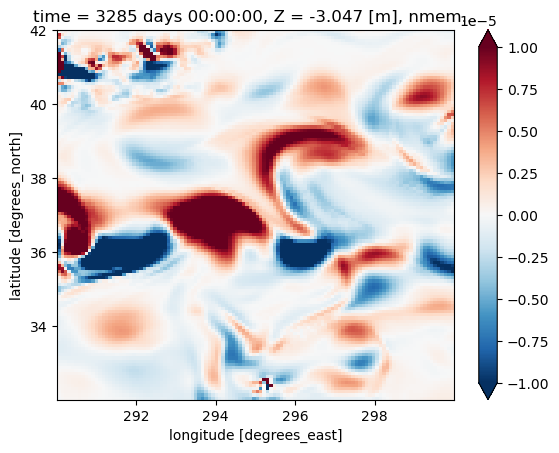

In [89]:
vm_on = (dsVm.Vm_Advec - dsVm.Vm_Cori).where(ds.maskS!=0.)
vm_on.isel(nmemb=0,Z=0).plot(vmax=1e-5)

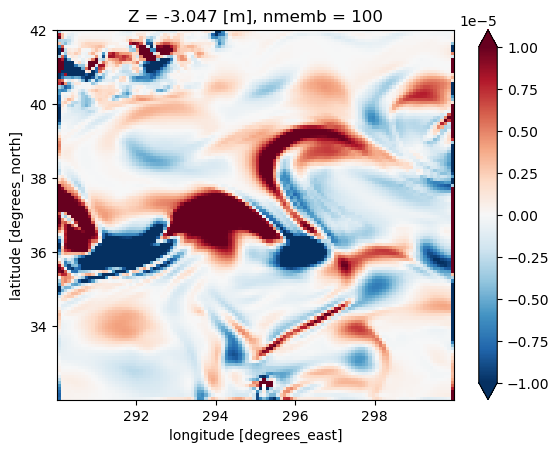

In [47]:
vm_off_xgcm,_,_,_ = advec_vm(ds, ds.VVEL)
# vm_off = xr.DataArray(vm_off, dims=vm_on.isel(nmemb=0).dims, 
#                       coords=vm_on.isel(nmemb=0).coords)
vm_off_xgcm.isel(nmemb=0, Z=0).plot(vmax=1e-5)

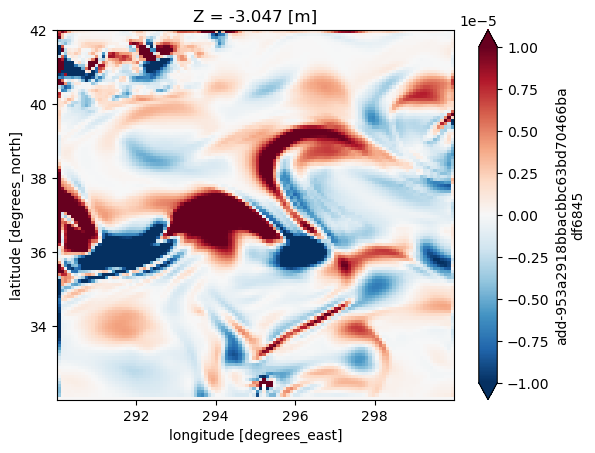

In [42]:
vm_off,_,_,_ = advec_vm(ds.isel(nmemb=0), ds.VVEL.isel(nmemb=0), xgcm_flag=False)
# vm_off = xr.DataArray(vm_off, dims=vm_on.isel(nmemb=0).dims, 
#                       coords=vm_on.isel(nmemb=0).coords)
vm_off.isel(Z=0).plot(vmax=1e-5)

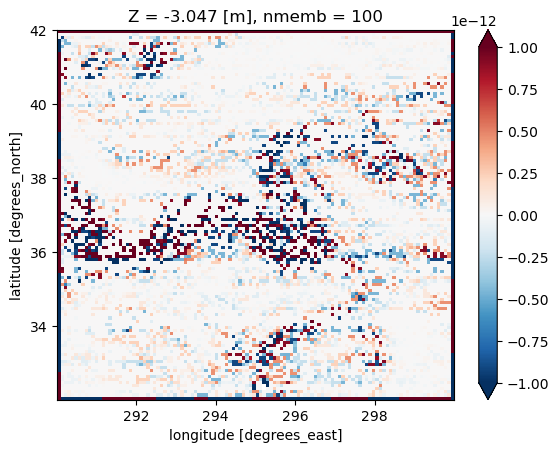

In [50]:
(vm_off - vm_off_xgcm.isel(nmemb=0)).isel(Z=0).plot(vmax=1e-12)

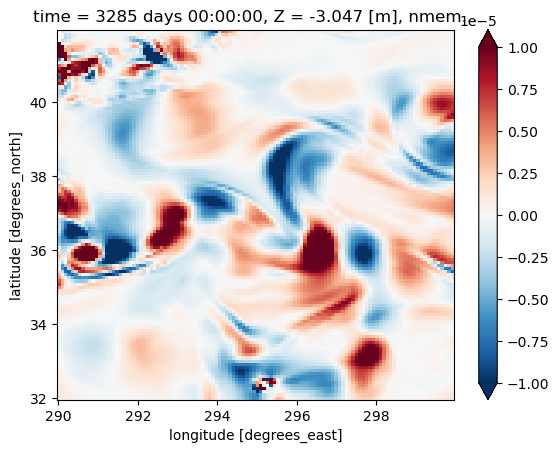

In [91]:
um_on = (dsUm.Um_Advec - dsUm.Um_Cori).where(ds.maskW!=0.)
um_on.isel(nmemb=0,Z=0).plot(vmax=1e-5)

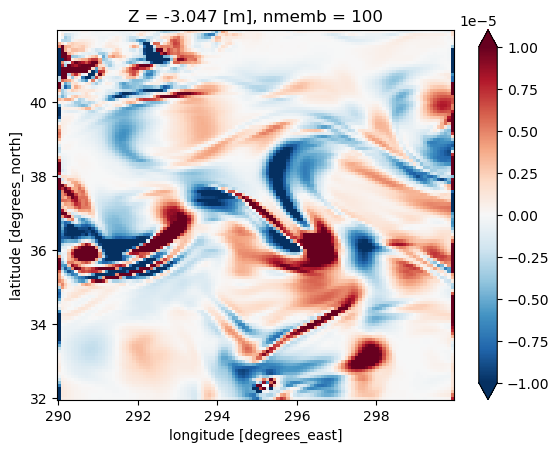

In [51]:
um_off_xgcm,_,_,_ = advec_um(ds, ds.UVEL)
# vm_off = xr.DataArray(vm_off, dims=vm_on.isel(nmemb=0).dims, 
#                       coords=vm_on.isel(nmemb=0).coords)
um_off_xgcm.isel(nmemb=0,Z=0).plot(vmax=1e-5)

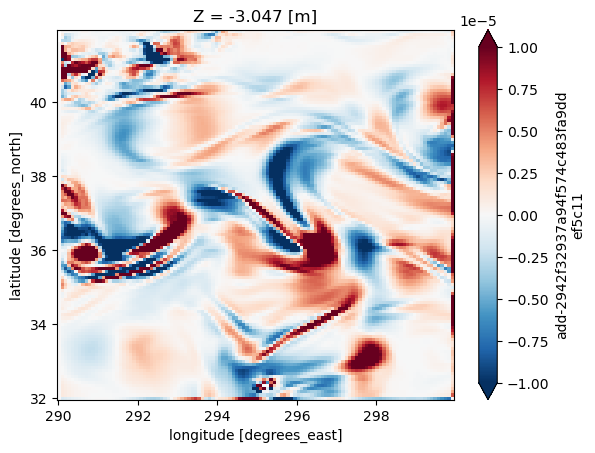

In [35]:
um_off,_,_,_ = advec_um(ds.isel(nmemb=0), ds.UVEL.isel(nmemb=0), xgcm_flag=False)
# um_off = xr.DataArray(um_off, dims=um_on.isel(nmemb=0).dims, 
#                       coords=um_on.isel(nmemb=0).coords)
um_off.isel(Z=0).plot(vmax=1e-5)

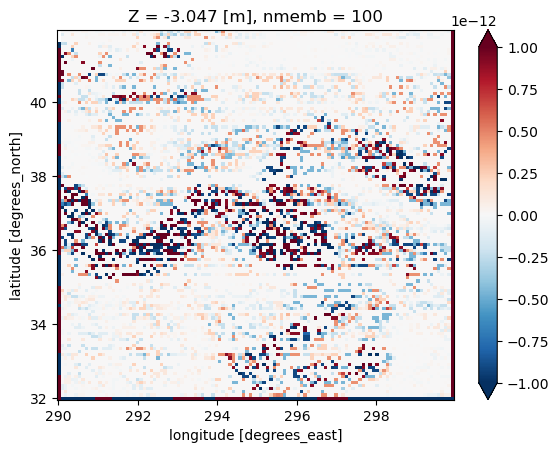

In [52]:
(um_off - um_off_xgcm.isel(nmemb=0)).isel(Z=0).plot(vmax=1e-12)

In [78]:
up = (ds.UVEL - dsb.UVEL).where(ds.maskW!=0.)
vp = (ds.VVEL - dsb.VVEL).where(ds.maskS!=0.)
wp = (ds.WVEL - dsb.WVEL)

ub = dsb.UVEL.where(ds.maskW!=0.)
vb = dsb.VVEL.where(ds.maskS!=0.)
wb = dsb.WVEL

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(


In [11]:
xA = (ds.dyG * ds.drF).reset_coords(drop=True)
yA = (ds.dxG * ds.drF).reset_coords(drop=True)

upTrans = up * xA
vpTrans = vp * yA
rpTrans = grid.interp(wp * ds.rA,'X',boundary='extend')
Auup = (grid.interp(upTrans,'X',boundary='extend')
        * grid.interp(up,'X',boundary='extend')
       )
Avup = (grid.interp(vpTrans,'X',boundary='extend')
        * grid.interp(up,'Y',boundary='extend')
       )
Awup = (rpTrans
        * grid.interp(up,'Z',boundary='extend')
       )
Aup = ((grid.diff(Auup,'X',boundary='extend')
        + grid.diff(Avup,'Y',boundary='extend')
        - grid.diff(Awup,'Z',boundary='extend')
       ) / ds.drF/ds.rAw
      ).where(ds.maskW!=0.).reset_coords(drop=True).mean('nmemb',skipna=True)

ubTrans = ub * xA
vbTrans = vb * yA
rbTrans = grid.interp(wb * ds.rA,'X',boundary='extend')
Auub = (grid.interp(ubTrans,'X',boundary='extend')
        * grid.interp(ub,'X',boundary='extend')
       )
Avub = (grid.interp(vbTrans,'X',boundary='extend')
        * grid.interp(ub,'Y',boundary='extend')
       )
Awub = (rbTrans
        * grid.interp(ub,'Z',boundary='extend')
       )
Aub = ((grid.diff(Auub,'X',boundary='extend')
        + grid.diff(Avub,'Y',boundary='extend')
        - grid.diff(Awub,'Z',boundary='extend')
       ) / ds.drF/ds.rAw
      ).where(ds.maskW!=0.).reset_coords(drop=True)
Aup

<xarray.DataArray (Z: 46, YC: 120, XG: 116)>
dask.array<mean_agg-aggregate, shape=(46, 120, 116), dtype=float32, chunksize=(1, 120, 116), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XG       (XG) >f4 290.0 290.1 290.2 290.3 290.4 ... 299.7 299.7 299.8 299.9
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03

Text(0.5, 1.0, 'Total (mean+eddy) advect.')

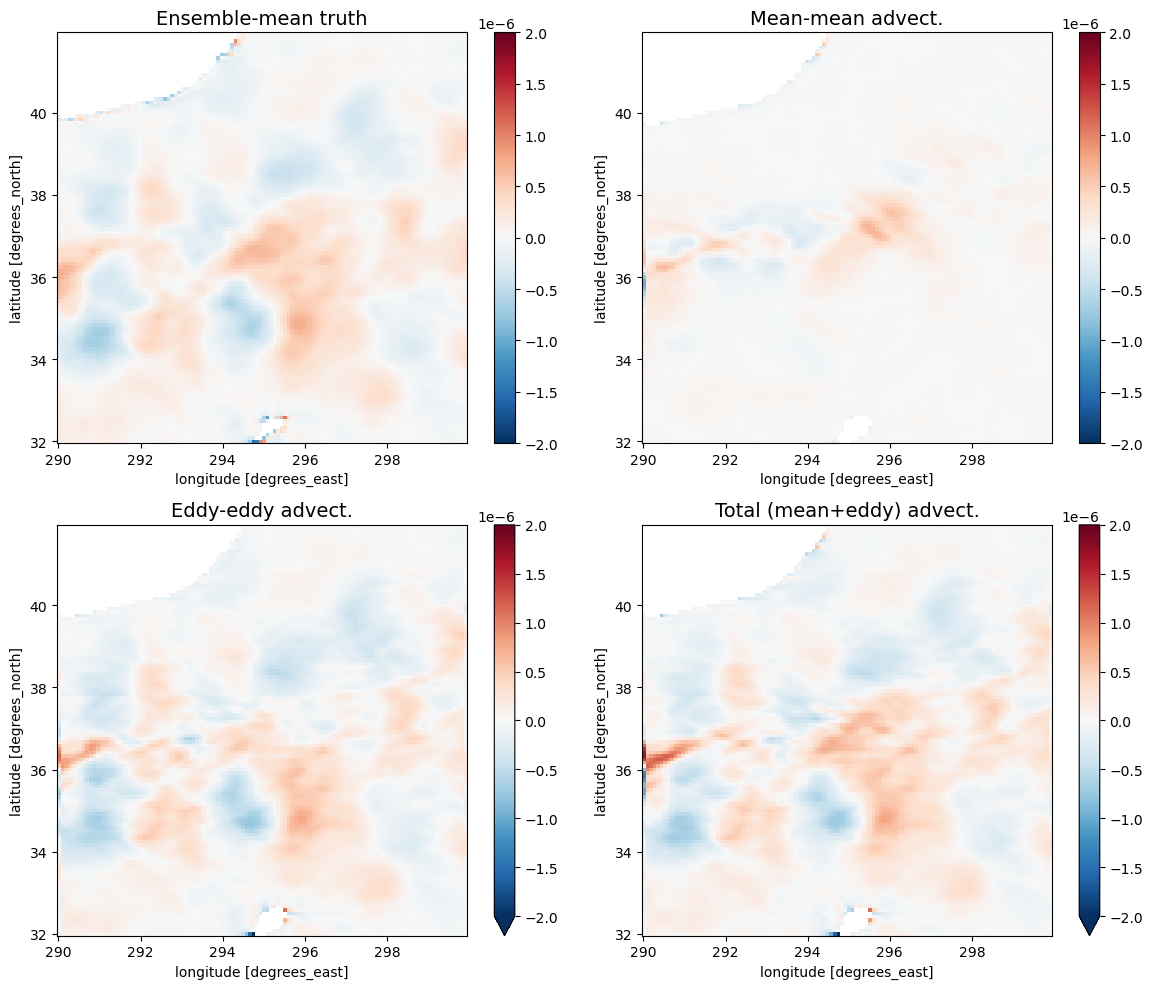

In [16]:
fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=2)
fig.set_tight_layout(True)

(dsUm.Um_Advec
 - dsUm.Um_Cori
).where(ds.maskW!=0.).isel(Z=18).mean('nmemb',skipna=True).plot(ax=axes[0,0], vmin=-2e-6, vmax=2e-6,
                                                                cmap='RdBu_r')
(-Aub).isel(Z=18).plot(ax=axes[0,1], vmin=-2e-6, vmax=2e-6, cmap='RdBu_r')
(-Aup).isel(Z=18).plot(ax=axes[1,0], vmin=-2e-6, vmax=2e-6, cmap='RdBu_r')
(-Aub-Aup).isel(Z=18).plot(ax=axes[1,1], vmin=-2e-6, vmax=2e-6, cmap='RdBu_r')

axes[0,0].set_aspect('equal')
axes[0,1].set_aspect('equal')
axes[1,0].set_aspect('equal')
axes[1,1].set_aspect('equal')

axes[0,0].set_title(r"Ensemble-mean truth", fontsize=14)
axes[0,1].set_title(r"Mean-mean advect.", fontsize=14)
axes[1,0].set_title(r"Eddy-eddy advect.", fontsize=14)
axes[1,1].set_title(r"Total (mean+eddy) advect.", fontsize=14)

In [8]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1576800,dnf).reshape(len(years),nfile)
dd = 69  # 
yystart = 0
ntimes[yystart,dd:][::3]

array([1568160, 1574640])

## Snapshots

<xarray.Dataset>
Dimensions:   (YC: 900, XG: 1000, Z: 1, nmemb: 48, XC: 1000, YG: 900)
Coordinates:
  * YC        (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG        (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * Z         (Z) >f4 -93.59
  * nmemb     (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * XC        (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YG        (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
Data variables:
    Um_Advec  (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 1, 200, 200), meta=np.ndarray>
    ADVx_Um   (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 200, 200), meta=np.ndarray>
    ADVy_Um   (nmemb, Z, YG, XG) float32 dask.array<chunksize=(1, 1, 200, 200), meta=np.ndarray>


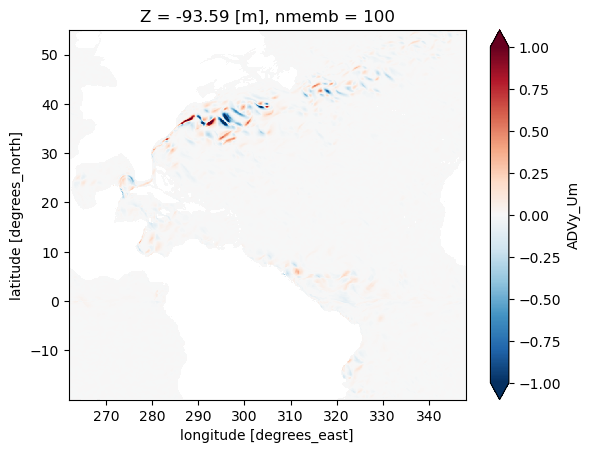

1419120
1425600
1432080
1438560
1445040
1451520
1458000
1464480
1470960
1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [12]:
nmembs = np.arange(100,148)
Zs = [9]


for iiter in ntimes[0,dd:][::3]:
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(
                               # YC=slice(15-dg/12,50+dg/12),
                               # YG=slice(15-dg/12,50+dg/12),
                               # XC=slice(273-dg/12,330+dg/12),
                               # XG=slice(273-dg/12,330+dg/12)
                              ).isel(time=0
                                    ).chunk({'YG':ychunk,'YC':ychunk,
                                             'XG':xchunk,'XC':xchunk,
                                             # 'Z':1
                                            })
    # if len(dsb.XG) > len(dsb.XC):
    #     dsb = dsb.isel(XG=slice(None,-1))
    # elif len(dsb.XG) < len(dsb.XC):
    #     dsb = dsb.isel(XC=slice(1,None))  
                
    for nmemb in nmembs:
        if nmemb == nmembs[0]:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(
                                      # YC=slice(15-dg/12,50+dg/12),
                                      # YG=slice(15-dg/12,50+dg/12),
                                      # XC=slice(273-dg/12,330+dg/12),
                                      # XG=slice(273-dg/12,330+dg/12)
                                     ).isel(time=0
                                           ).chunk({'YG':ychunk,'YC':ychunk,
                                                    'XG':xchunk,'XC':xchunk,
                                                    # 'Z':1
                                                   })
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%02d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn',], 
                                                delta_t=2e2, iters=iiter         
                                               ).isel(time=0, 
                                                     ).chunk({'YC':ychunk,
                                                              'YG':ychunk,
                                                              'XC':xchunk,
                                                              'XG':xchunk})
                            ], 'nmemb')
        
        # if len(ds.XG) > len(ds.XC):
        #     ds = ds.isel(XG=slice(None,-1))
        # elif len(ds.XG) < len(ds.XC):
        #     ds = ds.isel(XC=slice(1,None)) 
    ds.coords['nmemb'] = nmembs
    
    ub = dsb.UVEL
    vb = dsb.VVEL
    wb = dsb.WVEL
    up = (ds.UVEL - ub)
    vp = (ds.VVEL - vb)
    wp = (ds.WVEL - wb)
        
        
#         if nmemb == 100:
#             Vm_Advec, ADVx_Vm, ADVy_Vm = hori_advec_vm(ds, vp.data)
#             Um_Advec, ADVx_Um, ADVy_Um = hori_advec_um(ds, up.data)
            
#             Vm_Advec = Vm_Advec.isel(Z=Zs)
#             Um_Advec = Um_Advec.isel(Z=Zs)
#             ADVx_Vm = ADVx_Vm.isel(Z=Zs)
#             ADVy_Vm = ADVy_Vm.isel(Z=Zs)
#             ADVx_Um = ADVx_Um.isel(Z=Zs)
#             ADVy_Um = ADVy_Um.isel(Z=Zs)
            
#             if iiter == ntimes[0,dd]:
#                 grid = Grid(ds, periodic=['X'])
#                 (grid.interp(ds.VVEL,'Y',boundary='extend') 
#                  * grid.interp(up,'X')
#                 ).isel(Z=0).plot(rasterized=True, vmax=1)
#                 plt.show()
#         else:
#             _Vm_Advec, _ADVx_Vm, _ADVy_Vm = hori_advec_vm(ds, vp.data)
#             _Um_Advec, _ADVx_Um, _ADVy_Um = hori_advec_um(ds, up.data)

#             Vm_Advec = xr.concat([Vm_Advec, _Vm_Advec.isel(Z=Zs)], 'nmemb')
#             Um_Advec = xr.concat([Um_Advec, _Um_Advec.isel(Z=Zs)], 'nmemb')
#             ADVx_Vm = xr.concat([ADVx_Vm, _ADVx_Vm.isel(Z=Zs)], 'nmemb')
#             ADVx_Um = xr.concat([ADVx_Um, _ADVx_Um.isel(Z=Zs)], 'nmemb')
#             ADVy_Vm = xr.concat([ADVy_Vm, _ADVy_Vm.isel(Z=Zs)], 'nmemb')
#             ADVy_Um = xr.concat([ADVy_Um, _ADVy_Um.isel(Z=Zs)], 'nmemb')
            
#             del _Vm_Advec, _ADVx_Vm, _ADVy_Vm, _Um_Advec, _ADVx_Um, _ADVy_Um
        
        
    Vm_Advec, ADVx_Vm, ADVy_Vm = hori_advec_vm(ds, vp)
    Um_Advec, ADVx_Um, ADVy_Um = hori_advec_um(ds, up) 
        
    dsave = Vm_Advec.isel(Z=Zs).to_dataset(name='Vm_Advec')
    dsave['ADVx_Vm'] = ADVx_Vm.isel(Z=Zs)
    dsave['ADVy_Vm'] = ADVy_Vm.isel(Z=Zs)
    dsave.coords['nmemb'] = ('nmemb',nmembs)
    dsave.isel(
               # YC=slice(1,-1),YG=slice(1,-1),
               # XC=slice(1,-1),XG=slice(1,-1)
              ).chunk({'YG':ychunk,'YC':ychunk,
                       'XG':xchunk,'XC':xchunk,
                       # 'Z':1
                     }).to_zarr(op.join(savedir, 'Snap/Eddy_horiAdv/Z094/V_%010d.zarr' 
                                        % iiter), mode='w'
                               )
        
    dsave.close()
    dsave = Um_Advec.isel(Z=Zs).to_dataset(name='Um_Advec')
    dsave['ADVx_Um'] = ADVx_Um.isel(Z=Zs)
    dsave['ADVy_Um'] = ADVy_Um.isel(Z=Zs)
    dsave.coords['nmemb'] = ('nmemb',nmembs)
    if iiter == ntimes[0,dd]:
        print(dsave)
        dsave.ADVy_Um.isel(nmemb=0,Z=0).plot(rasterized=True, vmax=1)
        plt.show()
    dsave.isel(
               # YC=slice(1,-1),YG=slice(1,-1),
               # XC=slice(1,-1),XG=slice(1,-1)
              ).chunk({'YG':ychunk,'YC':ychunk,
                       'XG':xchunk,'XC':xchunk,
                       # 'Z':1
                     }).to_zarr(op.join(savedir, 'Snap/Eddy_horiAdv/Z094/U_%010d.zarr' 
                                        % iiter), mode='w'
                               )
    
    del Um_Advec, Vm_Advec, ADVx_Um, ADVy_Um, ADVx_Vm, ADVy_Vm
    dsave.close()
    ds.close()
    dsb.close()
    print(iiter)

<xarray.Dataset>
Dimensions:   (XC: 1000, YG: 900, Z: 1, nmemb: 48, XG: 1000, YC: 900, Zl: 2)
Coordinates:
  * XC        (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YG        (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
  * Z         (Z) >f4 -93.59
  * nmemb     (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * XG        (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YC        (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * Zl        (Zl) >f4 -84.95 -102.2
Data variables:
    Vm_Advec  (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 1, 200, 200), meta=np.ndarray>
    ADVx_Vm   (nmemb, Z, YG, XG) float32 dask.array<chunksize=(1, 1, 200, 200), meta=np.ndarray>
    ADVy_Vm   (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 200, 200), meta=np.ndarray>
    ADVz_Vm   (nmemb, Zl, YG, XC) float32 dask.array<chunksize=(1, 2, 200, 200), meta=np.ndarray>


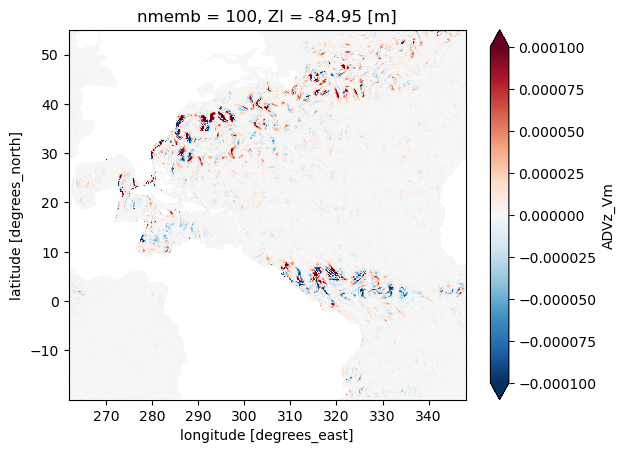

1568160
1574640


In [9]:
nmembs = np.arange(100,148)
Zs = [9]


for iiter in ntimes[0,dd:][::3]:
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(
                               # YC=slice(15-dg/12,50+dg/12),
                               # YG=slice(15-dg/12,50+dg/12),
                               # XC=slice(273-dg/12,330+dg/12),
                               # XG=slice(273-dg/12,330+dg/12)
                              ).isel(time=0
                                    ).chunk({'YG':ychunk,'YC':ychunk,
                                             'XG':xchunk,'XC':xchunk,
                                             # 'Z':1
                                            }) 
                
    for nmemb in nmembs:
        if nmemb == nmembs[0]:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(
                                      # YC=slice(15-dg/12,50+dg/12),
                                      # YG=slice(15-dg/12,50+dg/12),
                                      # XC=slice(273-dg/12,330+dg/12),
                                      # XG=slice(273-dg/12,330+dg/12)
                                     ).isel(time=0
                                           ).chunk({'YG':ychunk,'YC':ychunk,
                                                    'XG':xchunk,'XC':xchunk,
                                                    # 'Z':1
                                                   })
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,
                                                        'memb%02d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn',], 
                                                delta_t=2e2, iters=iiter
                                               ).isel(time=0, 
                                                     ).chunk({'YC':ychunk,
                                                              'YG':ychunk,
                                                              'XC':xchunk,
                                                              'XG':xchunk})
                            ], 'nmemb')
        
    ds.coords['nmemb'] = nmembs
    dse = ds - dsb
    
    up = dse.UVEL
    vp = dse.VVEL
    wp = dse.WVEL
        
    Vm_Advec, ADVx_Vm, ADVy_Vm, ADVz_Vm = advec_vm(dse, vp)
    Um_Advec, ADVx_Um, ADVy_Um, ADVz_Um = advec_um(dse, up) 
        
    dsave = Vm_Advec.isel(Z=Zs).to_dataset(name='Vm_Advec')
    dsave['ADVx_Vm'] = ADVx_Vm.isel(Z=Zs)
    dsave['ADVy_Vm'] = ADVy_Vm.isel(Z=Zs)
    dsave['ADVz_Vm'] = ADVz_Vm.isel(Zl=[Zs[0],Zs[0]+1])
    dsave.coords['nmemb'] = ('nmemb',nmembs)
    if iiter == ntimes[0,dd]:
        print(dsave)
        dsave.ADVz_Vm.isel(nmemb=0,Zl=0).plot(rasterized=True, vmax=1e-4)
        plt.show()
    dsave.isel(
               # YC=slice(1,-1),YG=slice(1,-1),
               # XC=slice(1,-1),XG=slice(1,-1)
              ).chunk({'YG':ychunk,'YC':ychunk,
                       'XG':xchunk,'XC':xchunk,
                       # 'Z':1
                     }).to_zarr(op.join(savedir, 
                                        'Snap/Eddy-eddy_Adv/Z094/V_%010d.zarr' 
                                        % iiter), mode='w'
                               )
        
    dsave.close()
    dsave = Um_Advec.isel(Z=Zs).to_dataset(name='Um_Advec')
    dsave['ADVx_Um'] = ADVx_Um.isel(Z=Zs)
    dsave['ADVy_Um'] = ADVy_Um.isel(Z=Zs)
    dsave['ADVz_Um'] = ADVz_Um.isel(Zl=[Zs[0],Zs[0]+1])
    dsave.coords['nmemb'] = ('nmemb',nmembs)
    dsave.isel(
               # YC=slice(1,-1),YG=slice(1,-1),
               # XC=slice(1,-1),XG=slice(1,-1)
              ).chunk({'YG':ychunk,'YC':ychunk,
                       'XG':xchunk,'XC':xchunk,
                       # 'Z':1
                     }).to_zarr(op.join(savedir, 
                                        'Snap/Eddy-eddy_Adv/Z094/U_%010d.zarr' 
                                        % iiter), mode='w'
                               )
    
    del Um_Advec, Vm_Advec, ADVx_Um, ADVy_Um, ADVz_Um, ADVx_Vm, ADVy_Vm, ADVz_Vm
    dsave.close()
    ds.close()
    dsb.close()
    print(iiter)

<xarray.Dataset>
Dimensions:   (XC: 1000, YG: 900, Z: 1, nmemb: 48, YC: 900, XG: 1000)
Coordinates:
  * XC        (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YG        (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
  * Z         (Z) >f4 -93.59
  * nmemb     (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * YC        (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG        (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
Data variables:
    Vm_Advec  (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 1, 200, 200), meta=np.ndarray>
    Um_Advec  (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 1, 200, 200), meta=np.ndarray>


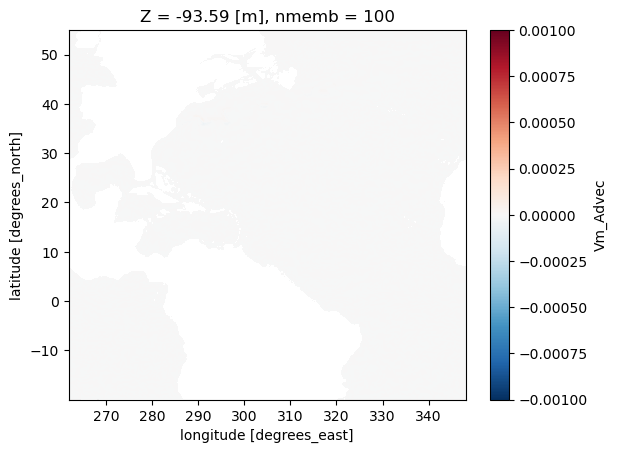

1419120
1425600
1432080
1438560
1445040
1451520
1458000
1464480
1470960
1477440
1483920
1490400
1496880
1503360
1509840
1516320
1522800
1529280
1535760
1542240
1548720
1555200
1561680
1568160
1574640


In [14]:
nmembs = np.arange(100,148)
Zs = [9]


for iiter in ntimes[0,dd:][::3]:
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(
                               # YC=slice(15-dg/12,50+dg/12),
                               # YG=slice(15-dg/12,50+dg/12),
                               # XC=slice(273-dg/12,330+dg/12),
                               # XG=slice(273-dg/12,330+dg/12)
                              ).isel(time=0
                                    ).chunk({'YG':ychunk,'YC':ychunk,
                                             'XG':xchunk,'XC':xchunk,
                                             # 'Z':1
                                            }) 
                
    for nmemb in nmembs:
        if nmemb == nmembs[0]:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(
                                      # YC=slice(15-dg/12,50+dg/12),
                                      # YG=slice(15-dg/12,50+dg/12),
                                      # XC=slice(273-dg/12,330+dg/12),
                                      # XG=slice(273-dg/12,330+dg/12)
                                     ).isel(time=0
                                           ).chunk({'YG':ychunk,'YC':ychunk,
                                                    'XG':xchunk,'XC':xchunk,
                                                    # 'Z':1
                                                   })
        else:
            ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%02d/run1967/ocn/' 
                                                        % (nmemb)), 
                                                grid_dir=gdir,
                                                prefix=['snap_diagOcn',], 
                                                delta_t=2e2, iters=iiter
                                               ).isel(time=0, 
                                                     ).chunk({'YC':ychunk,
                                                              'YG':ychunk,
                                                              'XC':xchunk,
                                                              'XG':xchunk})
                            ], 'nmemb')
        
    ds.coords['nmemb'] = nmembs
    dse = ds - dsb
    
    up = dse.UVEL
    vp = dse.VVEL
    wp = dse.WVEL
        
    Vm_Advec, _, _ = hori_advec_vm(dse, vp)
    Um_Advec, _, _ = hori_advec_um(dse, up) 
        
    dsave = Vm_Advec.isel(Z=Zs).to_dataset(name='Vm_Advec')
    dsave['Um_Advec'] = Um_Advec.isel(Z=Zs)
    dsave.coords['nmemb'] = ('nmemb',nmembs)
    if iiter == ntimes[0,dd]:
        print(dsave)
        dsave.Vm_Advec.isel(nmemb=0,Z=0).plot(rasterized=True, vmax=1e-3)
        plt.show()
    dsave.isel(
               # YC=slice(1,-1),YG=slice(1,-1),
               # XC=slice(1,-1),XG=slice(1,-1)
              ).chunk({'YG':ychunk,'YC':ychunk,
                       'XG':xchunk,'XC':xchunk,
                       # 'Z':1
                     }).to_zarr(op.join(savedir, 
                                        'Snap/Eddy-eddy_horiAdv/Z094/UV_%010d.zarr' 
                                        % iiter), mode='w'
                               )
        
    dsave.close()
    del Um_Advec, Vm_Advec
    ds.close()
    dsb.close()
    print(iiter)

In [10]:
nmembs = np.arange(100,148)
Zs = [9]


for iiter in ntimes[0,:][::3]: 
                
    for nmemb in nmembs:
        ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                            ).sel(
                                  # YC=slice(15-dg/12,50+dg/12),
                                  # YG=slice(15-dg/12,50+dg/12),
                                  # XC=slice(273-dg/12,330+dg/12),
                                  # XG=slice(273-dg/12,330+dg/12)
                                 ).isel(time=0
                                       ).chunk({'YG':ychunk,'YC':ychunk,
                                                'XG':xchunk,'XC':xchunk,
                                                # 'Z':1
                                               })
        
        # if len(ds.XG) > len(ds.XC):
        #     ds = ds.isel(XG=slice(None,-1))
        # elif len(ds.XG) < len(ds.XC):
        #     ds = ds.isel(XC=slice(1,None)) 

        
#         Vm_Advec, ADVx_Vm, ADVy_Vm = hori_advec_vm(ds, ds.VVEL)
#         Um_Advec, ADVx_Um, ADVy_Um = hori_advec_um(ds, ds.UVEL)

#         Vm_Advec = Vm_Advec.isel(Z=Zs)
#         Um_Advec = Um_Advec.isel(Z=Zs)
#         ADVx_Vm = ADVx_Vm.isel(Z=Zs)
#         ADVy_Vm = ADVy_Vm.isel(Z=Zs)
#         ADVx_Um = ADVx_Um.isel(Z=Zs)
#         ADVy_Um = ADVy_Um.isel(Z=Zs)
        if nmemb == 100:
            Vm_Advec, ADVx_Vm, ADVy_Vm = hori_advec_vm(ds, ds.VVEL.data)
            Um_Advec, ADVx_Um, ADVy_Um = hori_advec_um(ds, ds.UVEL.data)
            
            Vm_Advec = Vm_Advec.isel(Z=Zs)
            Um_Advec = Um_Advec.isel(Z=Zs)
            ADVx_Vm = ADVx_Vm.isel(Z=Zs)
            ADVy_Vm = ADVy_Vm.isel(Z=Zs)
            ADVx_Um = ADVx_Um.isel(Z=Zs)
            ADVy_Um = ADVy_Um.isel(Z=Zs)
            
            if iiter == ntimes[0,dd]:
                grid = Grid(ds, periodic=['X'])
                (grid.interp(ds.VVEL,'Y',boundary='extend') 
                 * grid.interp(ds.UVEL,'X')
                ).isel(Z=0).plot(rasterized=True, vmax=1)
                plt.show()
        else:
            _Vm_Advec, _ADVx_Vm, _ADVy_Vm = hori_advec_vm(ds, ds.VVEL.data)
            _Um_Advec, _ADVx_Um, _ADVy_Um = hori_advec_um(ds, ds.UVEL.data)

            Vm_Advec = xr.concat([Vm_Advec, _Vm_Advec.isel(Z=Zs)], 'nmemb')
            Um_Advec = xr.concat([Um_Advec, _Um_Advec.isel(Z=Zs)], 'nmemb')
            ADVx_Vm = xr.concat([ADVx_Vm, _ADVx_Vm.isel(Z=Zs)], 'nmemb')
            ADVx_Um = xr.concat([ADVx_Um, _ADVx_Um.isel(Z=Zs)], 'nmemb')
            ADVy_Vm = xr.concat([ADVy_Vm, _ADVy_Vm.isel(Z=Zs)], 'nmemb')
            ADVy_Um = xr.concat([ADVy_Um, _ADVy_Um.isel(Z=Zs)], 'nmemb')
            
            del _Vm_Advec, _ADVx_Vm, _ADVy_Vm, _Um_Advec, _ADVx_Um, _ADVy_Um
        
        
        ds.close()
    # dsb.close()  
        
    dsave = Vm_Advec.to_dataset(name='Vm_Advec')
    dsave['ADVx_Vm'] = ADVx_Vm
    dsave['ADVy_Vm'] = ADVy_Vm
    dsave.coords['nmemb'] = ('nmemb',nmembs)
    dsave.isel(
               # YC=slice(1,-1),YG=slice(1,-1),
               # XC=slice(1,-1),XG=slice(1,-1)
              ).chunk({'YG':ychunk,'YC':ychunk,
                       'XG':xchunk,'XC':xchunk,
                       'Z':1
                     }).to_zarr(op.join(savedir, 
                                        'Snap/Tot_horiAdv/Z094/V_%010d.zarr' 
                                        % iiter), mode='w'
                               )
    dsave = Um_Advec.to_dataset(name='Um_Advec')
    dsave['ADVx_Um'] = ADVx_Um
    dsave['ADVy_Um'] = ADVy_Um
    dsave.coords['nmemb'] = ('nmemb',nmembs)
    if iiter == ntimes[0,dd]:
        print(dsave)
        dsave.ADVy_Um.isel(nmemb=0,Z=0).plot(rasterized=True, vmax=1)
        plt.show()
    dsave.isel(
               # YC=slice(1,-1),YG=slice(1,-1),
               # XC=slice(1,-1),XG=slice(1,-1)
              ).chunk({'YG':ychunk,'YC':ychunk,
                       'XG':xchunk,'XC':xchunk,
                       'Z':1
                     }).to_zarr(op.join(savedir, 
                                        'Snap/Tot_horiAdv/Z094/U_%010d.zarr' 
                                        % iiter), mode='w'
                               )
        
    dsave.close()
    print(iiter)

TypeError: All data arguments must be either a DataArray or Dictionary Got <class 'dask.array.core.Array'>.

## 5Dave

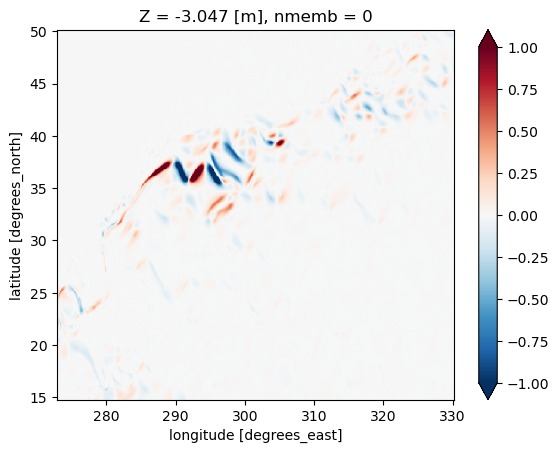

<xarray.Dataset>
Dimensions:   (XC: 666, YG: 424, Z: 2, nmemb: 48, YC: 424, XG: 666)
Coordinates:
  * XC        (XC) >f4 272.9 273.0 273.1 273.2 273.3 ... 329.9 330.0 330.1 330.2
  * YG        (YG) >f4 14.88 14.96 15.04 15.13 15.21 ... 49.88 49.96 50.04 50.13
  * Z         (Z) >f4 -3.047 -452.4
  * YC        (YC) >f4 14.83 14.92 15.0 15.08 15.17 ... 49.83 49.92 50.0 50.08
  * XG        (XG) >f4 272.9 273.0 273.1 273.1 273.2 ... 329.9 329.9 330.0 330.1
  * nmemb     (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 51 52 53 54 55 56 57 58 59
Data variables:
    Vm_Advec  (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 2, 424, 666), meta=np.ndarray>
    Um_Advec  (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 2, 424, 666), meta=np.ndarray>
    ADVx_Vm   (nmemb, Z, YG, XG) float32 dask.array<chunksize=(1, 2, 424, 666), meta=np.ndarray>
    ADVx_Um   (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 2, 424, 666), meta=np.ndarray>
    ADVy_Vm   (nmemb, Z, YC, XC) float32 dask.array<chunksize

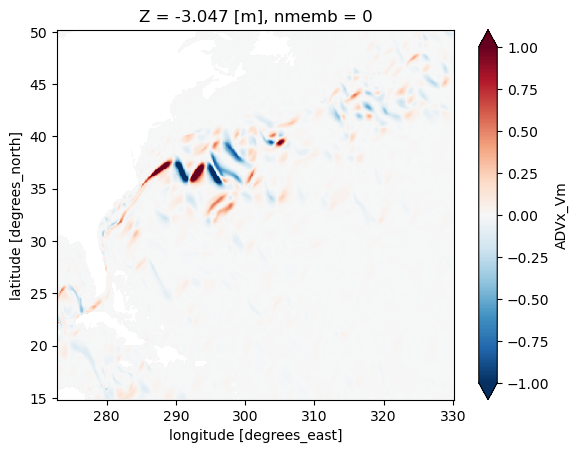

1421280
1427760
1434240
1440720
1447200
1453680
1460160
1466640
1473120
1479600
1486080
1492560
1499040
1505520
1512000
1518480
1524960
1531440
1537920
1544400
1550880
1557360
1563840
1570320
1576800


In [10]:
nntimes = np.arange(1421280,1576800+dnf,dnf)
tdir = '/tank/chaocean/qjamet/RUNS/ORAR/'
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))

Zs = [0,18]
dg = 2

for iiter in nntimes[::3]:
    # dsb = open_mdsdataset(op.join(tdir,'ensmean/run1967/'), 
    #                       grid_dir=gdir,
    #                       prefix=['diag_ocnTave'], delta_t=2e2,
    #                       iters=iiter, 
    #                      ).sel(YC=slice(15-dg/12,50+dg/12),
    #                            YG=slice(15-dg/12,50+dg/12),
    #                            XC=slice(273-dg/12,330+dg/12),
    #                            XG=slice(273-dg/12,330+dg/12)
    #                           ).isel(time=0)
    # if len(dsb.XG) > len(dsb.XC):
    #     dsb = dsb.isel(XG=slice(None,-1))
    # elif len(dsb.XG) < len(dsb.XC):
    #     dsb = dsb.isel(XC=slice(1,None))  
                
    for nmemb in nmembs:
        if nmemb == nmembs[0]:
            ds = open_mdsdataset(op.join(tdir,'memb%02d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['diag_ocnTave'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(YC=slice(15-dg/12,50+dg/12),
                                      YG=slice(15-dg/12,50+dg/12),
                                      XC=slice(273-dg/12,330+dg/12),
                                      XG=slice(273-dg/12,330+dg/12)
                                     ).isel(time=0)
        else:
            tmp = open_mdsdataset(op.join(tdir,'memb%02d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['diag_ocnTave'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(YC=slice(15-dg/12,50+dg/12),
                                      YG=slice(15-dg/12,50+dg/12),
                                      XC=slice(273-dg/12,330+dg/12),
                                      XG=slice(273-dg/12,330+dg/12)
                                     ).isel(time=0)
            ds = xr.concat([ds, tmp], 'nmemb')
            tmp.close()
        
    if len(ds.XG) > len(ds.XC):
        ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
        ds = ds.isel(XC=slice(1,None)) 
        
    ds.coords['nmemb'] = ('nmemb',nmembs)

    ub = ds.UVEL.mean('nmemb')
    vb = ds.VVEL.mean('nmemb')
    wb = ds.WVEL.mean('nmemb')
    up = (ds.UVEL - ub)
    vp = (ds.VVEL - vb)
    wp = (ds.WVEL - wb)
    
    for nmemb in nmembs:
        if nmemb == nmembs[0]:
            Vm_Advec, ADVx_Vm, ADVy_Vm = hori_advec_vm(ds.sel(nmemb=nmemb), 
                                                       vp.sel(nmemb=nmemb).data)
            Um_Advec, ADVx_Um, ADVy_Um = hori_advec_um(ds.sel(nmemb=nmemb), 
                                                       up.sel(nmemb=nmemb).data)
            
            Vm_Advec = Vm_Advec.isel(Z=Zs)
            Um_Advec = Um_Advec.isel(Z=Zs)
            ADVx_Vm = ADVx_Vm.isel(Z=Zs)
            ADVy_Vm = ADVy_Vm.isel(Z=Zs)
            ADVx_Um = ADVx_Um.isel(Z=Zs)
            ADVy_Um = ADVy_Um.isel(Z=Zs)
            
            if iiter == nntimes[0]:
                grid = Grid(ds, periodic=[])
                (grid.interp(ds.UVEL,'X',boundary='extend') 
                 * grid.interp(vp,'Y',boundary='extend')
                ).isel(nmemb=nmembs[0],Z=0).plot(rasterized=True, vmax=1)
                plt.show()
        else:
            _Vm_Advec, _ADVx_Vm, _ADVy_Vm = hori_advec_vm(ds.sel(nmemb=nmemb), 
                                                          vp.sel(nmemb=nmemb).data)
            _Um_Advec, _ADVx_Um, _ADVy_Um = hori_advec_um(ds.sel(nmemb=nmemb), 
                                                          up.sel(nmemb=nmemb).data)

            Vm_Advec = xr.concat([Vm_Advec, _Vm_Advec.isel(Z=Zs)], 'nmemb')
            Um_Advec = xr.concat([Um_Advec, _Um_Advec.isel(Z=Zs)], 'nmemb')
            ADVx_Vm = xr.concat([ADVx_Vm, _ADVx_Vm.isel(Z=Zs)], 'nmemb')
            ADVx_Um = xr.concat([ADVx_Um, _ADVx_Um.isel(Z=Zs)], 'nmemb')
            ADVy_Vm = xr.concat([ADVy_Vm, _ADVy_Vm.isel(Z=Zs)], 'nmemb')
            ADVy_Um = xr.concat([ADVy_Um, _ADVy_Um.isel(Z=Zs)], 'nmemb')
            
            del _Vm_Advec, _ADVx_Vm, _ADVy_Vm, _Um_Advec, _ADVx_Um, _ADVy_Um
        
        
        ds.close()
    # dsb.close()  
        
    dsave = Vm_Advec.to_dataset(name='Vm_Advec')
    dsave['Um_Advec'] = Um_Advec
    dsave['ADVx_Vm'] = ADVx_Vm
    dsave['ADVx_Um'] = ADVx_Um
    dsave['ADVy_Vm'] = ADVy_Vm
    dsave['ADVy_Um'] = ADVy_Um
    dsave.coords['nmemb'] = ('nmemb',nmembs)
    if iiter == nntimes[0]:
        print(dsave)
        dsave.ADVx_Vm.isel(nmemb=nmembs[0],Z=0).plot(rasterized=True, vmax=1)
        plt.show()
    dsave.isel(YC=slice(1,-1),YG=slice(1,-1),
               XC=slice(1,-1),XG=slice(1,-1)
              ).chunk({'YG':ychunk,'YC':ychunk,
                       'XG':xchunk,'XC':xchunk,
                       'Z':1
                     }).to_zarr(op.join(savedir, '5Dave/Eddy_horiAdv%010d.zarr' 
                                        % iiter), mode='w'
                               )
        
    dsave.close()
    print(iiter)

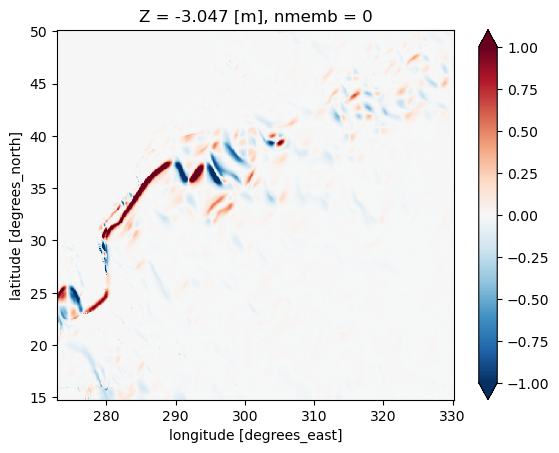

<xarray.Dataset>
Dimensions:   (XC: 666, YG: 424, Z: 2, nmemb: 48, YC: 424, XG: 666)
Coordinates:
  * XC        (XC) >f4 272.9 273.0 273.1 273.2 273.3 ... 329.9 330.0 330.1 330.2
  * YG        (YG) >f4 14.88 14.96 15.04 15.13 15.21 ... 49.88 49.96 50.04 50.13
  * Z         (Z) >f4 -3.047 -452.4
  * YC        (YC) >f4 14.83 14.92 15.0 15.08 15.17 ... 49.83 49.92 50.0 50.08
  * XG        (XG) >f4 272.9 273.0 273.1 273.1 273.2 ... 329.9 329.9 330.0 330.1
  * nmemb     (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 51 52 53 54 55 56 57 58 59
Data variables:
    Vm_Advec  (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 2, 424, 666), meta=np.ndarray>
    Um_Advec  (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 2, 424, 666), meta=np.ndarray>
    ADVx_Vm   (nmemb, Z, YG, XG) float32 dask.array<chunksize=(1, 2, 424, 666), meta=np.ndarray>
    ADVx_Um   (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 2, 424, 666), meta=np.ndarray>
    ADVy_Vm   (nmemb, Z, YC, XC) float32 dask.array<chunksize

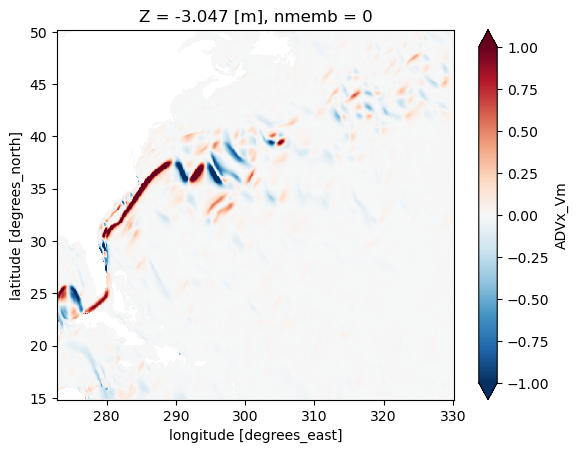

1421280
1427760
1434240
1440720
1447200
1453680
1460160
1466640
1473120
1479600
1486080
1492560
1499040
1505520
1512000
1518480
1524960
1531440
1537920
1544400
1550880
1557360
1563840
1570320
1576800


In [10]:
nntimes = np.arange(1421280,1576800+dnf,dnf)
tdir = '/tank/chaocean/qjamet/RUNS/ORAR/'
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))

Zs = [0,18]
dg = 2

for iiter in nntimes[::3]:
    # dsb = open_mdsdataset(op.join(tdir,'ensmean/run1967/'), 
    #                       grid_dir=gdir,
    #                       prefix=['diag_ocnTave'], delta_t=2e2,
    #                       iters=iiter, 
    #                      ).sel(YC=slice(15-dg/12,50+dg/12),
    #                            YG=slice(15-dg/12,50+dg/12),
    #                            XC=slice(273-dg/12,330+dg/12),
    #                            XG=slice(273-dg/12,330+dg/12)
    #                           ).isel(time=0)
    # if len(dsb.XG) > len(dsb.XC):
    #     dsb = dsb.isel(XG=slice(None,-1))
    # elif len(dsb.XG) < len(dsb.XC):
    #     dsb = dsb.isel(XC=slice(1,None))  
                
    for nmemb in nmembs:
        if nmemb == nmembs[0]:
            ds = open_mdsdataset(op.join(tdir,'memb%02d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['diag_ocnTave'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(YC=slice(15-dg/12,50+dg/12),
                                      YG=slice(15-dg/12,50+dg/12),
                                      XC=slice(273-dg/12,330+dg/12),
                                      XG=slice(273-dg/12,330+dg/12)
                                     ).isel(time=0)
        else:
            tmp = open_mdsdataset(op.join(tdir,'memb%02d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['diag_ocnTave'], delta_t=2e2,
                                 iters=iiter, 
                                ).sel(YC=slice(15-dg/12,50+dg/12),
                                      YG=slice(15-dg/12,50+dg/12),
                                      XC=slice(273-dg/12,330+dg/12),
                                      XG=slice(273-dg/12,330+dg/12)
                                     ).isel(time=0)
            ds = xr.concat([ds, tmp], 'nmemb')
            tmp.close()
        
    if len(ds.XG) > len(ds.XC):
        ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
        ds = ds.isel(XC=slice(1,None)) 
        
    ds.coords['nmemb'] = ('nmemb',nmembs)

    
    for nmemb in nmembs:
        if nmemb == nmembs[0]:
            Vm_Advec, ADVx_Vm, ADVy_Vm = hori_advec_vm(ds.sel(nmemb=nmemb), 
                                                       ds.VVEL.sel(nmemb=nmemb).data)
            Um_Advec, ADVx_Um, ADVy_Um = hori_advec_um(ds.sel(nmemb=nmemb), 
                                                       ds.UVEL.sel(nmemb=nmemb).data)
            
            Vm_Advec = Vm_Advec.isel(Z=Zs)
            Um_Advec = Um_Advec.isel(Z=Zs)
            ADVx_Vm = ADVx_Vm.isel(Z=Zs)
            ADVy_Vm = ADVy_Vm.isel(Z=Zs)
            ADVx_Um = ADVx_Um.isel(Z=Zs)
            ADVy_Um = ADVy_Um.isel(Z=Zs)
            
            if iiter == nntimes[0]:
                grid = Grid(ds, periodic=[])
                (grid.interp(ds.UVEL,'X',boundary='extend') 
                 * grid.interp(ds.VVEL,'Y',boundary='extend')
                ).isel(nmemb=nmembs[0],Z=0).plot(rasterized=True, vmax=1)
                plt.show()
        else:
            _Vm_Advec, _ADVx_Vm, _ADVy_Vm = hori_advec_vm(ds.sel(nmemb=nmemb), 
                                                          ds.VVEL.sel(nmemb=nmemb).data)
            _Um_Advec, _ADVx_Um, _ADVy_Um = hori_advec_um(ds.sel(nmemb=nmemb), 
                                                          ds.UVEL.sel(nmemb=nmemb).data)

            Vm_Advec = xr.concat([Vm_Advec, _Vm_Advec.isel(Z=Zs)], 'nmemb')
            Um_Advec = xr.concat([Um_Advec, _Um_Advec.isel(Z=Zs)], 'nmemb')
            ADVx_Vm = xr.concat([ADVx_Vm, _ADVx_Vm.isel(Z=Zs)], 'nmemb')
            ADVx_Um = xr.concat([ADVx_Um, _ADVx_Um.isel(Z=Zs)], 'nmemb')
            ADVy_Vm = xr.concat([ADVy_Vm, _ADVy_Vm.isel(Z=Zs)], 'nmemb')
            ADVy_Um = xr.concat([ADVy_Um, _ADVy_Um.isel(Z=Zs)], 'nmemb')
            
            del _Vm_Advec, _ADVx_Vm, _ADVy_Vm, _Um_Advec, _ADVx_Um, _ADVy_Um
        
        
        ds.close()
    # dsb.close()  
        
    dsave = Vm_Advec.to_dataset(name='Vm_Advec')
    dsave['Um_Advec'] = Um_Advec
    dsave['ADVx_Vm'] = ADVx_Vm
    dsave['ADVx_Um'] = ADVx_Um
    dsave['ADVy_Vm'] = ADVy_Vm
    dsave['ADVy_Um'] = ADVy_Um
    dsave.coords['nmemb'] = ('nmemb',nmembs)
    if iiter == nntimes[0]:
        print(dsave)
        dsave.ADVx_Vm.isel(nmemb=nmembs[0],Z=0).plot(rasterized=True, vmax=1)
        plt.show()
    dsave.isel(YC=slice(1,-1),YG=slice(1,-1),
               XC=slice(1,-1),XG=slice(1,-1)
              ).chunk({'YG':ychunk,'YC':ychunk,
                       'XG':xchunk,'XC':xchunk,
                       'Z':1
                     }).to_zarr(op.join(savedir, '5Dave/Tot_horiAdv%010d.zarr' 
                                        % iiter), mode='w'
                               )
        
    dsave.close()
    print(iiter)